In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Message:
    def __init__(self, information, veracity):
        self.information = information
        self.veracity = veracity

class BiasedAgent:
    def __init__(self, unique_id, true_state, incoming_message):
        self.unique_id = unique_id
        self.true_state = true_state
        self.incoming_message = incoming_message

    def communication_strat(self):
        judgement = None
        # Create a new message if agent is the first agent
        if self.unique_id == 0 and self.true_state == 1:
            judgement = 1
            self.incoming_message = Message(self.true_state, judgement)
        elif self.incoming_message == 1:
            judgement = 1
            message = Message(information = judgement, veracity=self.true_state)
            return message



class UnbiasedAgent:
    def __init__(self, unique_id, prior_belief, p_tie, true_state, incoming_message, share_biased_agents):
        self.unique_id = unique_id
        self.p_tie = p_tie
        self.prior_belief = prior_belief
        self.true_state = true_state
        self.incoming_message = incoming_message
        self.share_biased_agents = share_biased_agents
        self.new_belief = self.update_belief()

    def update_belief(self):
        return self.prior_belief/(self.share_biased_agents+(1-self.share_biased_agents*self.prior_belief))

    def communication_strat(self):
        judgement = None
        if self.unique_id == 0:
            if self.true_state == 0:
                judgement = 0
            elif self.true_state==1 and self.prior_belief > 0.5:
                judgement = 1
            self.incoming_message = Message(self.true_state, judgement)
        elif self.unique_id >0:
            if self.incoming_message.information == 0:
                judgement = 0
            elif self.incoming_message.information == 0 and self.new_belief>0.5:
                judgement = 1
            message = Message(self.true_state, judgement)
            return message


In [9]:
class RumorModel:
    def __init__(self, N, prior_belief, p_bias, p_tie, h, true_state):
        self.num_agents = N
        self.prior_belief = prior_belief
        self.p_bias = p_bias
        self.p_tie = p_tie
        self.h = h
        self.schedule = []
        self.true_state = true_state
        self.num_biased_agents = 0
        self.evaluate_self_correction = []

    def run_model(self):
        for i in range(self.num_agents):
            # Init Message
            if i == 0 and  random.random() < self.p_bias:
                b = BiasedAgent(unique_id=i, true_state = self.true_state, incoming_message=None)
                self.schedule.append(b)
                self.num_biased_agents+=1

            elif i == 0:
                u = UnbiasedAgent(unique_id = i, prior_belief=self.prior_belief, true_state=self.true_state, incoming_message=None, p_tie = self.p_tie, share_biased_agents=0)
                self.schedule.append(u)

            biased_prob = random.random()
            if i>0 and biased_prob < self.p_bias:
                connect, similar = self.connection_prob()
                if connect:
                    index = len(self.schedule)-1
                else:
                    index = random.randint(0,len(self.schedule)-1)
                agent_to_connect = self.schedule[index]
                if similar and isinstance(agent_to_connect, BiasedAgent):
                    b = BiasedAgent(i,  true_state = self.true_state, incoming_message=agent_to_connect.incoming_message)
                    self.schedule.append(b)
                    self.num_biased_agents+=1
                elif not connect:
                    b = BiasedAgent(i,  true_state = self.true_state, incoming_message=agent_to_connect.incoming_message)
                    self.schedule.append(b)
                    self.num_biased_agents+=1

            elif i>0 and biased_prob > self.p_bias:
                connect, similar = self.connection_prob()
                if connect:
                    index = len(self.schedule)-1
                else:
                    index = random.randint(0,len(self.schedule)-1)
                agent_to_connect = self.schedule[index]

                if similar and isinstance(agent_to_connect, UnbiasedAgent):
                    u = UnbiasedAgent(unique_id = i, prior_belief=self.prior_belief, true_state=self.true_state, incoming_message=agent_to_connect.incoming_message, p_tie = self.p_tie, share_biased_agents=self.num_biased_agents/self.num_agents)
                    if u.update_belief()>0.5:
                        self.evaluate_self_correction.append(1)
                    else:
                        self.evaluate_self_correction.append(0)
                    self.schedule.append(u)

                elif not connect:
                    u = UnbiasedAgent(unique_id = i, prior_belief=self.prior_belief, true_state=self.true_state, incoming_message=agent_to_connect.incoming_message, p_tie = self.p_tie, share_biased_agents=self.num_biased_agents/self.num_agents)
                    if u.update_belief()>0.5:
                        self.evaluate_self_correction.append(1)
                    else:
                        self.evaluate_self_correction.append(0)
                    self.schedule.append(u)



# Determining whether agents connect to prior agent or to randomly chosen other agent
    def connection_prob(self):
        connect, similar = False, False
        if self.p_tie > random.random():
            connect = True
        if self.h > random.random():
            similar = True
        return connect, similar



In [4]:
model = RumorModel(N=10000, prior_belief=0.5, p_bias=0.5, p_tie=0.9, h=0.1, true_state=True)
model.run_model()

NameError: name 'i' is not defined

(0.0, 1.1)

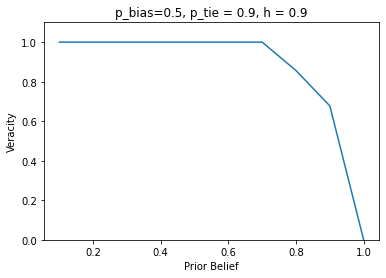

In [46]:
ranges = np.arange(0.1, 1.1, 0.1)
results = []

for i in ranges:
    model = RumorModel(N=10000, prior_belief=0.6, p_bias=i, p_tie=0.9, h=0.9, true_state=False)
    model.run_model()
    try:
        results.append(sum(model.evaluate_self_correction) / len(model.evaluate_self_correction))
    except ZeroDivisionError:
        results.append(0)
plt.plot(ranges, results)
plt.xlabel('Prior Belief')
plt.ylabel('Veracity')
plt.title("p_bias=0.5, p_tie = 0.9, h = 0.9")
plt.ylim(0, 1.1)
#plt.savefig('prior_1.png')

In [20]:
!ls

model.ipynb  p_bias_1.png  p_bias.png  prior_1.png  prior.png
